In [3]:
# Python ≥3.5 is required
import sys

import keras.datasets.mnist

print("Python: ", sys.version_info)
assert sys.version_info >= (3, 7)

# Scikit-Learn ≥0.20 is required
import sklearn
print("sklearn version: ", sklearn.__version__)
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.8 is required
import tensorflow as tf
print("TF version: ", tf.__version__)
# assert tf.__version__ >= "2.8"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# GPU test
print("GPU installed: ",tf.test.is_built_with_gpu_support())

# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

# Common imports
import numpy as np
import os
import pandas as pd
import tensorflow_datasets as tfds
from tensorflow_datasets.core.utils import gcs_utils
gcs_utils._is_gcs_disabled = True


# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

2024-05-01 06:31:53.352401: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 06:31:53.352438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 06:31:53.353078: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-01 06:31:53.357364: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 06:31:54.021426: W tensorflow/compiler/tf2

Python:  sys.version_info(major=3, minor=9, micro=19, releaselevel='final', serial=0)
sklearn version:  1.4.1.post1
TF version:  2.15.0


2024-05-01 06:31:55.331808: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-01 06:31:55.362607: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-01 06:31:55.362660: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-01 06:31:55.366306: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-01 06:31:55.366362: I external/local_xla/xla/stream_executor

GPU installed:  True
1 Physical GPUs, 1 Logical GPUs


In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### get the data(EMNIST)

In [5]:
tf.data.Dataset


tensorflow.python.data.ops.dataset_ops.DatasetV2

In [6]:
import tensorflow_datasets as tfds
from tensorflow_datasets.core.utils import gcs_utils
gcs_utils._is_gcs_disabled = True

ds, info = tfds.load('emnist/balanced', split='train', with_info=True)

fig = tfds.show_examples(ds, info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

NonMatchingChecksumError: Artifact https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip, downloaded to /home/choi-wsl/tensorflow_datasets/downloads/itl.nist.gov_iaui_vip_cs_links_EMNIST_gzipi4VnNviDSrfd9Zju6qv40flc3wr22t8ldulNStS6tmk.zip.tmp.4cb32132354442b0b8009000a522f83b/itl, has wrong checksum:
* Expected: UrlInfo(size=535.73 MiB, checksum='fb9bb67e33772a9cc0b895e4ecf36d2cf35be8b709693c3564cea2a019fcda8e', filename='gzip.zip')
* Got: UrlInfo(size=109.56 KiB, checksum='4c365a0821a9ac9b77fb572075f3edd0c30d595720783028bac06e6f7bd4f8c0', filename='itl')
To debug, see: https://www.tensorflow.org/datasets/overview#fixing_nonmatchingchecksumerror

In [9]:
tfds.load('covid19')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

ModuleNotFoundError: No module named 'apache_beam'
Failed importing apache_beam. This likely means that the dataset requires additional dependencies that have to be manually installed (usually with `pip install apache_beam`). See setup.py extras_require.

In [10]:
eminst_builder = tfds.builder("emnist")
eminst_info = eminst_builder.info

In [11]:
eminst_builder.download_and_prepare()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

NonMatchingChecksumError: Artifact https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip, downloaded to /home/choi-wsl/tensorflow_datasets/downloads/itl.nist.gov_iaui_vip_cs_links_EMNIST_gzipi4VnNviDSrfd9Zju6qv40flc3wr22t8ldulNStS6tmk.zip.tmp.e79d3a4ef175426db128387a852cd322/itl, has wrong checksum:
* Expected: UrlInfo(size=535.73 MiB, checksum='fb9bb67e33772a9cc0b895e4ecf36d2cf35be8b709693c3564cea2a019fcda8e', filename='gzip.zip')
* Got: UrlInfo(size=109.56 KiB, checksum='709989c87965a3f9fef64926f0395f5063e904b9d2861dc2e2a9347d55414b52', filename='itl')
To debug, see: https://www.tensorflow.org/datasets/overview#fixing_nonmatchingchecksumerror

[cannot load..](https://github.com/tensorflow/datasets/issues/5356)

In [86]:
dpath = Path() / "datasets" / "emnist"
print(dpath)

train_bal = pd.read_csv(dpath / "emnist-balanced-train.csv")
test_bal = pd.read_csv(dpath / "emnist-balanced-test.csv")

datasets/emnist


In [85]:
print(np.shape(train_bal))
print(np.shape(test_bal))

(18799, 785)
(112799, 785)


In [8]:
num_columns = 785

# Create column names
columns = ['label'] + list(range(1, num_columns))

# Assign column names to the DataFrames
train_bal.columns = columns
test_bal.columns = columns

# Reset index
train_bal = train_bal.reset_index(drop=True)
test_bal = test_bal.reset_index(drop=True)

# Extract features and labels
x_train = train_bal.drop(['label'], axis=1)
y_train = train_bal['label']
x_test = test_bal.drop(['label'], axis=1)
y_test = test_bal['label']

# Display the first few rows of the DataFrame
print(train_bal.head())
print(test_bal.head())

   label  1  2  3  4  5  6  7  8  9  ...  775  776  777  778  779  780  781  \
0     39  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
1      9  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
2     26  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
3     44  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
4     33  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   

   782  783  784  
0    0    0    0  
1    0    0    0  
2    0    0    0  
3    0    0    0  
4    0    0    0  

[5 rows x 785 columns]
   label  1  2  3  4  5  6  7  8  9  ...  775  776  777  778  779  780  781  \
0     36  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
1     43  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
2     15  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
3      4  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0 

In [24]:
train_bal["label"].value_counts()

label
39    400
38    400
23    400
5     400
25    400
31    400
17    400
34    400
0     400
18    400
36    400
19    400
20    400
32    400
13    400
42    400
24    400
10    400
46    400
30    400
15    400
22    400
1     400
43    400
9     400
2     400
26    400
44    400
33    400
14    400
11    400
3     400
12    400
16    400
7     400
27    400
21    400
6     400
28    400
45    400
29    400
8     400
4     400
35    400
40    400
37    400
41    399
Name: count, dtype: int64

In [71]:
labels = set(train_bal["label"].unique())
print(labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46}


In [72]:
file = open("datasets/emnist/emnist-balanced-mapping.txt",'r')
label_bal = []

lines = file.readlines()

for line in lines:
    label_bal.append(chr(int(line.split()[-1])))
    
file.close()

In [73]:
print(label_bal)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


each label - [link](https://www.kaggle.com/code/ashenonebot1/handwritten-digits-letters-classification)

In [28]:
y_train = np.array(train_bal.iloc[:,0].values)
x_train = np.array(train_bal.iloc[:,1:].values)

#test_set
y_test = np.array(test_bal.iloc[:,0].values)
x_test = np.array(test_bal.iloc[:,1:].values)
print(y_train)
print(x_train.shape)

[39  9 26 ...  1 26 33]
(18799, 784)


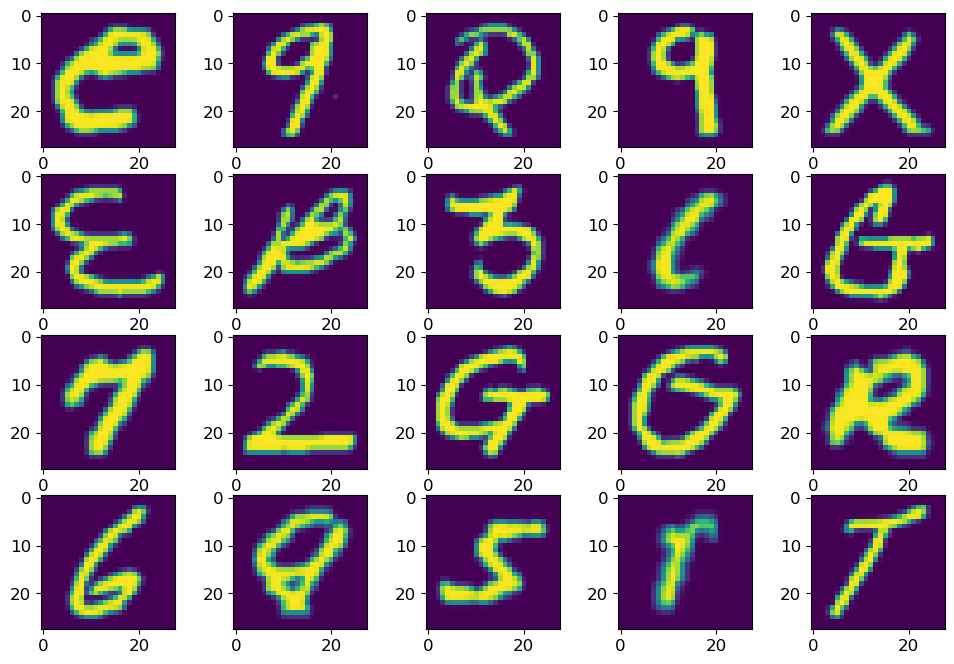

In [34]:
fig, axes = plt.subplots(4, 5,figsize=(12,8))

for i, j in enumerate(axes.flat):
    j.imshow(x_train[i].reshape([28,28]).transpose())

In [77]:
import matplotlib.pyplot as plt

def plot(image_data, label="nan"):
    image = image_data.reshape(28, 28)
    plt.imshow(image.transpose(), cmap="binary")
    plt.axis("off")
    plt.title(label)

def plot_multi(image_data, labels, row = 10, col = 10):
    plt.figure(figsize=(row-1,col-1))
    for idx, image in enumerate(image_data[:row*col]):
        plt.subplot(row, col, idx + 1)
        plot(image,label_bal[labels[idx]])
    # plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

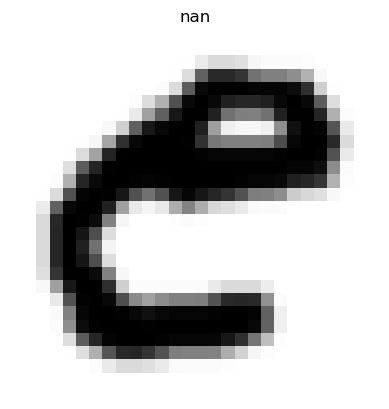

In [78]:
plot(x_train[0])

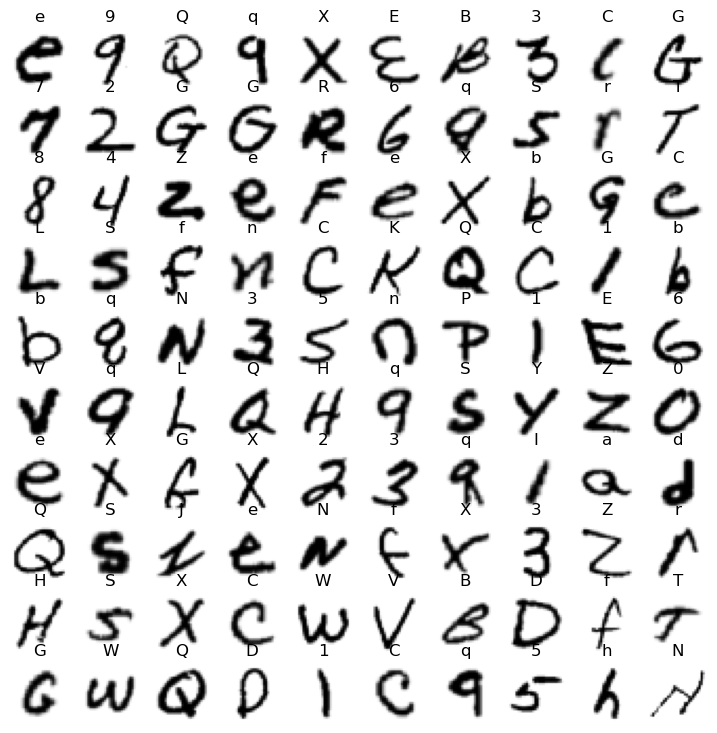

In [79]:
plot_multi(x_train,y_train)

## train(beta)

[link](https://www.kaggle.com/code/akankshajo/emnist-letter-dataset-97-9-acc-val-acc-91-78)
[and link](https://www.kaggle.com/code/ashenonebot1/handwritten-digits-letters-classification)

In [117]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

label_size = len(label_bal)

class Reshaper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_reshaped = X.reshape(-1, 28, 28, 1)
        return X_reshaped

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: StandardScaler
    ('reshaper', Reshaper())  # Step 2: Custom Reshaper
])


# Fit and transform the training data

x_train_processed = pipeline.fit_transform(x_train / 255.)
y_train_processed = np.eye(label_size)[y_train.astype(int)]

x_test_processed = pipeline.transform(x_test / 255.)

y_test_processed = np.eye(label_size)[y_test.astype(int)]

In [118]:
print('input shape',x_train_processed.shape)
print('output shape',y_train.shape)
# y_train = np.eye(62)[y_train.astype(int)]
print('output shape',y_train_processed.shape)

input shape (112799, 28, 28, 1)
output shape (112799,)
output shape (112799, 47)


In [119]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,Dropout

#  multiple model architectures
models = []
input_shape=(28,28,1)
output = 47

# Model 1
model1 = Sequential()
model1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model1.add(MaxPooling2D((2, 2)))
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(output, activation='softmax'))
models.append(model1)

# Model 2
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model2.add(Dropout(0.25)) 
model2.add(MaxPooling2D((2, 2)))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.4))
model2.add(Dense(output, activation='softmax'))
# Add layers for Model 2
models.append(model2)

# Model 3
model3 = Sequential()
model3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model3.add(Dropout(0.25)) 
model3.add(MaxPooling2D((2, 2)))
model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(output, activation='softmax'))
models.append(model3)

# Train each model
for i, model in enumerate(models):
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(x_train_processed, y_train_processed, epochs=5, batch_size=32)

# Evaluate each model
accuracies = []
for i, model in enumerate(models):
    loss, accuracy = model.evaluate(x_test_processed, y_test_processed)
    accuracies.append(accuracy)
    print(f"Model {i+1} Accuracy: {accuracy}")

# Select the best model based on accuracy
best_model_index = accuracies.index(max(accuracies))
best_model = models[best_model_index]
print(f"Best Model: Model {best_model_index+1}")

Epoch 1/5
3525/3525 [==============================] - 24s 6ms/step - loss: 0.7625 - accuracy: 0.7669
Epoch 2/5
3525/3525 [==============================] - 20s 6ms/step - loss: 0.4645 - accuracy: 0.8461
Epoch 3/5
3525/3525 [==============================] - 20s 6ms/step - loss: 0.3992 - accuracy: 0.8619
Epoch 4/5
3525/3525 [==============================] - 20s 6ms/step - loss: 0.3552 - accuracy: 0.8743
Epoch 5/5
3525/3525 [==============================] - 20s 6ms/step - loss: 0.3276 - accuracy: 0.8822
Epoch 1/5


2024-05-01 08:44:54.584418: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3525/3525 [==============================] - 22s 6ms/step - loss: 1.1672 - accuracy: 0.6503
Epoch 2/5
3525/3525 [==============================] - 22s 6ms/step - loss: 0.7558 - accuracy: 0.7592
Epoch 3/5
3525/3525 [==============================] - 22s 6ms/step - loss: 0.6799 - accuracy: 0.7808
Epoch 4/5
3525/3525 [==============================] - 22s 6ms/step - loss: 0.6374 - accuracy: 0.7935
Epoch 5/5
3525/3525 [==============================] - 22s 6ms/step - loss: 0.6006 - accuracy: 0.8023
Epoch 1/5


2024-05-01 08:46:45.289714: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3525/3525 [==============================] - 23s 6ms/step - loss: 1.0123 - accuracy: 0.6889
Epoch 2/5
3525/3525 [==============================] - 23s 7ms/step - loss: 0.6569 - accuracy: 0.7847
Epoch 3/5
3525/3525 [==============================] - 23s 7ms/step - loss: 0.5814 - accuracy: 0.8059
Epoch 4/5
3525/3525 [==============================] - 23s 6ms/step - loss: 0.5384 - accuracy: 0.8180
Epoch 5/5
588/588 [==============================] - 3s 5ms/step - loss: 0.4967 - accuracy: 0.8497
Model 1 Accuracy: 0.8496728539466858
588/588 [==============================] - 3s 6ms/step - loss: 0.4916 - accuracy: 0.8423
Model 2 Accuracy: 0.8423320651054382
588/588 [==============================] - 3s 5ms/step - loss: 0.4312 - accuracy: 0.8528
Model 3 Accuracy: 0.852811336517334
Best Model: Model 3


In [120]:
a = 1
